## Background

A pathologist's report after reviewing a patient's biological tissue samples is often the gold standard in the diagnosis of many diseases. For cancer, in particular, a pathologist's diagnosis has a profound impact on a patient's therapy. The reviewing of pathology slides is a very complex task, requiring years of training to gain the expertise and experience to do well.

Even with extensive training, there can be substantial variability in the diagnoses given by different pathologist for the same problem.

The lack of aggrement is not surprising given the massive amount of information that must be reviewed on order to make an accurate diagnosis.

### Pathologist workflow

Pathologist are responsible for reviwing all the biological tissues available in a slide.

## Approach

- Try different magnifications (much like what a pathologist does).


## Expected outcomes

- Prediction heatmaps?
- Preprocess image: Apply thresholding to reduce background noise.
- Transform from original RGB to HSV.


## References

- Deep Learning for Identifying Metastatic Breast Cancer (https://arxiv.org/pdf/1606.05718.pdf)
- Detecting Cancer Metastases on Gigapixel Pathology Images (https://arxiv.org/pdf/1703.02442.pdf)

## Imports

In [42]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# imports
import numpy as np
import pandas as pd
from glob import glob
import cv2
import os
import random
import matplotlib.pyplot as plt


In [44]:
# output files
TRAINING_LOG_FILE = "training_log.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_PLOT_FILE = "model_plot.png"
MODEL_FILE = "model.h5"
TRAINING_PLOT_FILE = "training.png"
VALIDATION_PLOT_FILE = "validation.png"
ROC_PLOT_FILE = "roc.png"
KAGGLE_SUBMISSION_FILE = "kaggle_submission.csv"
ORIGINAL_IMAGE_SIZE = 96

In [45]:
# hyperparams
SAMPLE_COUNT = 85000
TRAINING_RATION = 0.9
IMAGE_SIZE = 96
EPOCHS = 10
BATCH_SIZE = 192
VERBOSITY = 1
TESTING_BATCH_SIZE = 5000

## Data Path

In [46]:
# data
# PATH = '/datadrive/kaggle/histopathologic-cancer-detection'
PATH = 'E:\\kaggle\\histopathologic_cancer_detection'
# TRAIN = 'f{PATH}/train'
TRAIN = f'{PATH}\\train'
# TEST = 'f{PATH}/test'
TEST = f'{PATH}\\test'

In [47]:
# !ls {PATH}
!dir {PATH}


 Volume in drive E is Data
 Volume Serial Number is 4CC4-26B7

 Directory of E:\kaggle\histopathologic_cancer_detection

12/26/2018  02:06 AM    <DIR>          .
12/26/2018  02:06 AM    <DIR>          ..
12/25/2018  11:41 PM         2,470,703 sample_submission.csv
12/26/2018  12:01 AM    <DIR>          test
12/26/2018  01:11 AM    <DIR>          train
12/25/2018  11:41 PM         9,461,084 train_labels.csv
               2 File(s)     11,931,787 bytes
               4 Dir(s)  514,882,904,064 bytes free


## Firt look at images

In [48]:
def read_image(image_path):
    img = cv2.imread(image_path)
    b, g, r = cv2.split(img)
    rgb_img = cv2.merge([r, g, b])
    return rgb_img
    

In [49]:
def show_images(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])    

In [50]:
os.listdir(PATH)

['sample_submission.csv', 'test', 'train', 'train_labels.csv']

In [51]:
files = os.listdir(TRAIN)[:5]
files

['00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif',
 '000020de2aa6193f4c160e398a8edea95b1da598.tif',
 '00004aab08381d25d315384d646f5ce413ea24b1.tif',
 '0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif',
 '0000da768d06b879e5754c43e2298ce48726f722.tif']

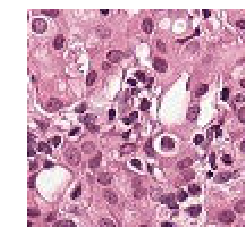

In [52]:
img = plt.imread(f'{PATH}/train/{files[0]}')
show_images([img], figsize=(8, 4))

In [57]:
print('Image resolution:', img.shape)

Image resolution: (96, 96, 3)


## Data exploration

In [58]:
#print(f'{PATH}/train_labels.csv')
train_labels_df = pd.read_csv(f'{PATH}/train_labels.csv', engine='python')
train_labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [59]:
train_labels_df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [60]:
negative_train = train_labels_df

## Our first model: Quick start